In [1]:
library(methylKit)
library(ggplot2)
library(tidyverse)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


At

In [2]:
sample_ids = c(
 'N1', # control
 'N2',
 'N3',
 'N4',
 'N5',
 'N6',
 'H26',
 'H28',

 'AC1', #stemi
 'AC2',
 'AC3',
 'AC4',
 'AC5',
 'AC6',
 'AC14',
 'AC15',

 'AC7',# nstemi
 'AC8',
 'AC9',
 'AC10',
 'AC11', 
 'AC12',
 'AC13',

 'AP1', #Acs/iAP
 'AP2',
 'AP3',
 'AP4',
 'AP5',  
 'AP6',

 'CS1', #CAD+posStressEcho
 'CS2',
 'CS3',
 'CS4', 
 'CS5',
 'CS6'
)

treatment_descr=c(
    rep("Control",8),  # control
    rep("ACS/Stemi",8), #stemi
    rep("ACS/Nstemi",7),  # nstemi
    rep("ACS/iAP",6), #Acs/iAP
    rep("CAD+posStressEcho",6) #CAD+posStressEcho
  )


treatment=c(
    rep(0,8),  # control
    rep(1,8), #stemi
    rep(2,7),  # nstemi
    rep(3,6), #Acs/iAP
    rep(4,6) #CAD+posStressEcho
     )
treatment1=c(
    rep(0,8),  # control
    rep(1,8), #stemi
    rep(2,7),  # nstemi
    rep(3,6), #Acs/iAP
    rep(4,3), #CAD+posStressEcho+negIntervention
    rep(5,3) #CAD+posStressEcho+posIntervention
     )



TBL = data.frame(sample_ids=sample_ids,
                 treatment_descr=treatment_descr,
                 treatment=treatment,
                 stringsAsFactors = FALSE)

In [48]:
methDB_discovery<-readRDS(file = "methDB_discovery.rds")

methDB_validation<-readRDS(file = "methDB_validation.rds")


In [ ]:
#myDiff25p_tiled_list_v1 <- readRDS("/local/AAkalin_cardiac/Results/cardiac/RDS/myDiff25p_tiled_list_v1.RDS")

In [10]:
methT.path = '/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1.txt.bgz'
meth.deT=methylKit:::readMethylBaseDB(methT.path,"tabix",
                 sample_ids, "hg38" ,"CpG",
                 "region",treatment,TRUE,skip=0)

In [4]:
dbdir.dm='/local/AAkalin_cardiac/Results/cardiac/differential_methylation/'


In [5]:
dmc_treat = 
lapply(c("ACS/Stemi","ACS/Nstemi" ,"ACS/iAP"),
  function(treat){

    TBL.subset=TBL[TBL$treatment_descr %in% c("Control", treat),]
    dbpath=paste0(dbdir.dm,
                          paste0("methylDiff_tiles_win500bp_step500bp_batch123", 
                                  "_treatment", 
                                  stringr::str_replace_all(treat, "[[:punct:]]", ""),
                                  ".txt.bgz"))
    methylKit:::readMethylDiffDB(dbpath,
                     "tabix",
                     TBL.subset$sample_ids, 
                     "hg38",
                     "CpG",
                     "region",
                     TBL.subset$treatment,
                     TRUE,
                     skip=0)
  })

No Tabix Header Found, 
Creating methylDiffDB using supplied arguments.

No Tabix Header Found, 
Creating methylDiffDB using supplied arguments.

No Tabix Header Found, 
Creating methylDiffDB using supplied arguments.



In [11]:
myDiff25p_tiled_list = lapply(dmc_treat, function(muDiff){
  getMethylDiff(muDiff,difference=1,qvalue=0.01,save.db = FALSE)
}); names(myDiff25p_tiled_list)=c("Stemi","Nstemi" ,"UA")

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.



In [17]:
#make a single dataframe with all coordinates of all DMRs (from all conditions) from discovery
concat_DMRs<-do.call(rbind, myDiff25p_tiled_list)
concat_DMRs <- concat_DMRs %>% select(chr,start,end) %>% unique()
#make a genomic range out of it
ranges_DMR<-makeGRangesFromDataFrame(concat_DMRs)

In [19]:
#ranges_DMR

In [22]:
DMR_discovery=regionCounts(object=meth.deT, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)
#methDB_DMR_discovery<-methylKit::unite(DMR_discovery,destrand = TRUE)


checking wether tabix file already exists:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions.txt.bgz

tabix file already exists, renaming output file:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions_1.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...



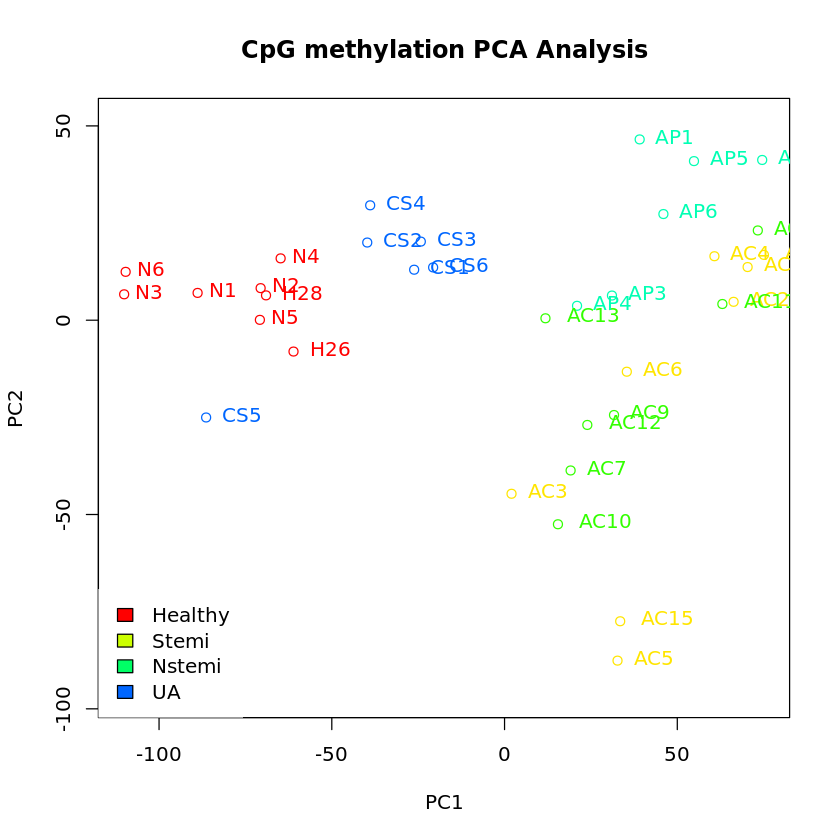

In [21]:
PCASamples(DMR_discovery)
legend("bottomleft",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)

In [30]:
#matrix with altas reference
extendedReference <- data.table::fread("extendedReference.csv")
#location of the cpgs 
cpg_tissuespec=data.table::fread("extendedReference_probeRegionInfo.csv")
#get only hg38 coordinates
cpg_tissuespec=cpg_tissuespec[-which(cpg_tissuespec$CHR_hg38==""),]
#renaming the cols
cpg_tissuespec<-cpg_tissuespec %>% dplyr::select(CpG,CHR_hg38,Start_hg38,End_hg38,Strand_hg38) %>% rename("chr"="CHR_hg38","start"="Start_hg38","end"="End_hg38","strand"="Strand_hg38")


In [32]:
#getting the extreme values (biggest distance from the avg) and the tissue/cell that has this extreme values (cell/tissue specific cpgs)
extendedReference <-extendedReference %>% remove_rownames %>% column_to_rownames(var="CpGs")
extendedReference$avg <- rowMeans(extendedReference)
extendedReference$max <-colnames(extendedReference[,1:28])[apply(extendedReference[,1:28], 1, which.max)]
extendedReference$min <-colnames(extendedReference[,1:28])[apply(extendedReference[,1:28], 1, which.min)]
extendedReference$max_value<-apply(X=extendedReference[,1:28], MARGIN=1, FUN=max)
extendedReference$min_value<-apply(X=extendedReference[,1:28], MARGIN=1, FUN=min)
extendedReference$max_mins_avg<- extendedReference$max_value - extendedReference$avg
extendedReference$avg_mins_min<- extendedReference$avg - extendedReference$min_value
extendedReference$specific <- ifelse(extendedReference$max_mins_avg >extendedReference$min_value, extendedReference$max, extendedReference$min)
cpgs_tissues<-extendedReference %>% dplyr::select(specific)

#merging the dataframe indicating CpGs --> tissue
cpgs_tissues <-tibble::rownames_to_column(cpgs_tissues, "CpG")
cpg_tissuespec <-merge(cpg_tissuespec,cpgs_tissues,by="CpG")
cpg_tissuespec_gr=makeGRangesFromDataFrame(cpg_tissuespec,
              keep.extra.columns=TRUE,
              ignore.strand=FALSE,       
              seqnames.field="chr",   
              start.field="start",    
              end.field="end",    
              strand.field="strand",   
              starts.in.df.are.0based=TRUE) 

cpg_tissuespec_grF = cpg_tissuespec_gr[strand(cpg_tissuespec_gr)=="+"]
cpg_tissuespec_grR = cpg_tissuespec_gr[strand(cpg_tissuespec_gr)=="-"]

cpg_tissuespec_grR = GRanges(seqnames(cpg_tissuespec_grR),
IRanges(start(cpg_tissuespec_grR)-1L,
end(cpg_tissuespec_grR)-1L),
"+",mcols=data.frame(cpg_tissuespec_grR) %>% dplyr::select(CpG,specific))
names(values(cpg_tissuespec_grR)) <-c("CpG","specific")

cpg_tissuespec_gr = sort(c(cpg_tissuespec_grF,cpg_tissuespec_grR))
end(cpg_tissuespec_gr) = end(cpg_tissuespec_gr)-1

In [33]:
cpg_tissuespec_gr

GRanges object with 12291 ranges and 2 metadata columns:
          seqnames    ranges strand |         CpG               specific
             <Rle> <IRanges>  <Rle> | <character>            <character>
      [1]     chr1    631732      + |  cg00645010  Pancreatic_duct_cells
      [2]     chr1    904372      + |  cg23733394   heart_left_ventricle
      [3]     chr1    943994      + |  cg10827460          Uterus_cervix
      [4]     chr1    944002      + |  cg15742605          Uterus_cervix
      [5]     chr1    944034      + |  cg09756115 Colon_epithelial_cells
      ...      ...       ...    ... .         ...                    ...
  [12287]    chr22  50505481      + |  cg14114931 Pancreatic_acinar_ce..
  [12288]    chr22  50542692      + |  cg08425796       Neutrophils_EPIC
  [12289]    chr22  50542976      + |  cg05418105       Neutrophils_EPIC
  [12290]    chr22  50627714      + |  cg13909895          NK-cells_EPIC
  [12291]    chr22  50784914      + |  cg07660283        CD8T-cells

In [40]:
left_ventricule_cpg=cpg_tissuespec_gr[(elementMetadata(cpg_tissuespec_gr)[,2] == "heart_left_ventricle")]



In [41]:
discovery_tissue_cpg=regionCounts(object=meth.deT, regions=cpg_tissuespec_gr, cov.bases=0,strand.aware=FALSE)



checking wether tabix file already exists:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions.txt.bgz

tabix file already exists, renaming output file:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions_3.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions.txt.bgz

tabix file already exists, renaming output file:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/tileMethylCounts/methylBase_CpG_dT_tiles_win500bp_step500bp_123batch_v1_regions_4.txt.bgz

HINT: consider using 'suf

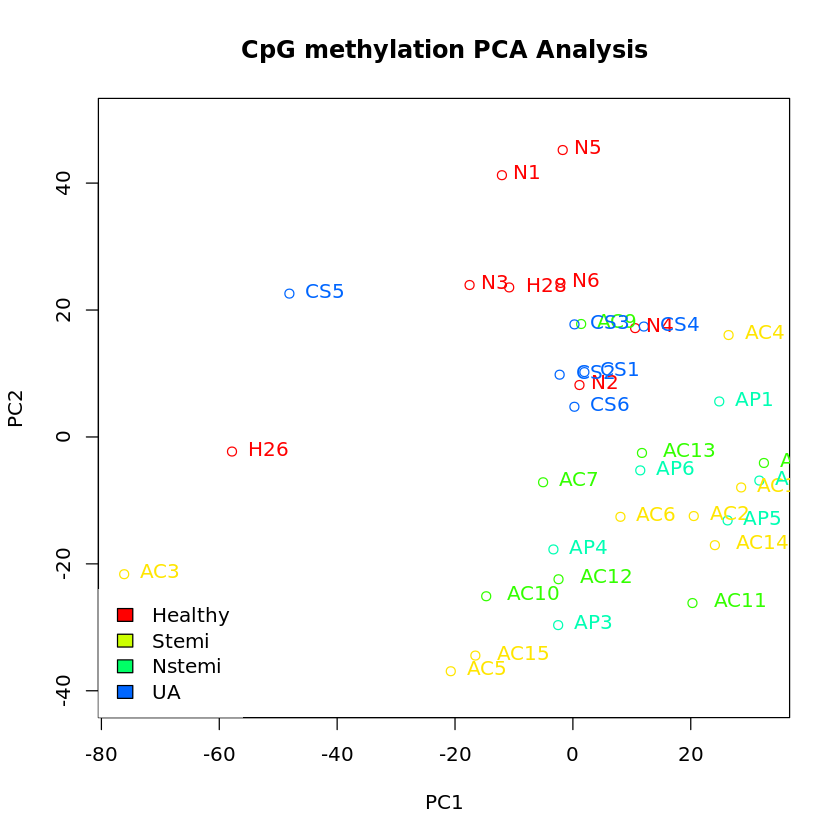

In [36]:
PCASamples(discovery_tissue_cpg)
legend("bottomleft",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)

In [ ]:
discovery_left_ventricule_cpg=regionCounts(object=meth.deT, regions=left_ventricule_cpg, cov.bases=0,strand.aware=FALSE)


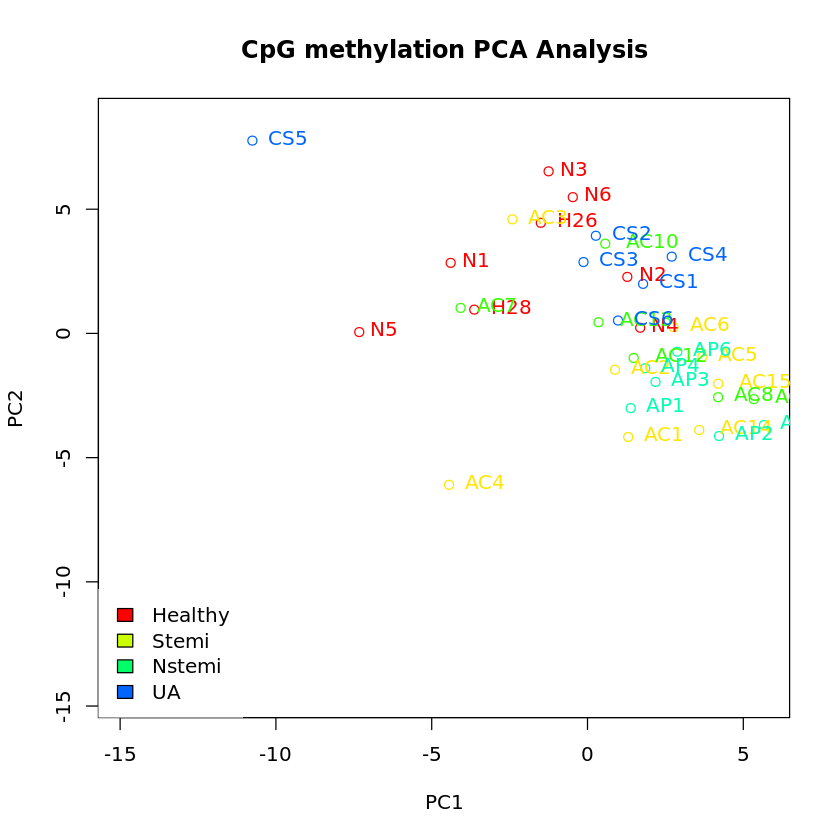

In [42]:
PCASamples(discovery_left_ventricule_cpg)
legend("bottomleft",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)

In [52]:
methDB_validation<-readRDS(file = "methRawList_validation.rds")


In [53]:
validation_left_ventricule_cpg=regionCounts(object=methDB_validation, regions=left_ventricule_cpg, cov.bases=0,strand.aware=FALSE)
methDB_validation_left_ventricule_cpg=methylKit::unite(validation_left_ventricule_cpg,destrand = TRUE)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_59.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_59.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing t

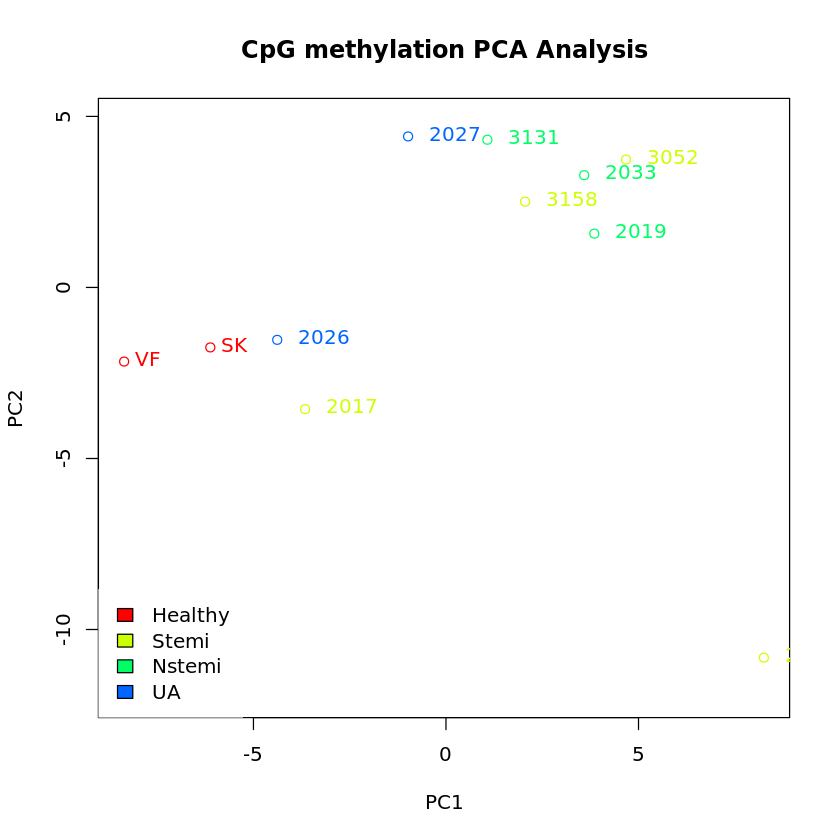

In [57]:
PCASamples(methDB_validation_left_ventricule_cpg)
legend("bottomleft",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)